In [121]:
import json
from collections import defaultdict
import numpy as np
import pandas as pd
from nltk.corpus import wordnet as wn

import seaborn as sns
import matplotlib.pyplot as plt

In [156]:
gloss_samples_file = 'data/RuShiftEval/GlossInter/top_all_glosses_chervyak_rusemshift.txt'
all_data_samples_file = 'data/RuSemShift/dev.rusemshift_1.data'
target_lemma = 'червяк'

In [157]:
with open(all_data_samples_file) as f:
    data_samples = json.load(f)
#     for sample in data_samples:
#         if sample['grp'] == "COMPARE":
#             if 'ъ ' in sample['sentence2']:
#                 print(sample)
                
len(data_samples)

4107

In [158]:
with open(gloss_samples_file) as f:
    gloss_samples = json.load(f)
    
len(gloss_samples)

61

In [159]:
epochs = defaultdict(lambda: defaultdict(int))

data_samples_dict = {sample['id']: sample for sample in data_samples}

for sample in gloss_samples:
    if sample['lemma'] != target_lemma:
        continue
    current_data_sample = data_samples_dict[sample['id']]
    if current_data_sample['grp'] == 'EARLIER':
        for gloss_info in sample['glosses1']:
            epochs[gloss_info['synset']]['epoch_1'] += gloss_info['similarity']
        for gloss_info in sample['glosses2']:
            epochs[gloss_info['synset']]['epoch_1'] += gloss_info['similarity']
    elif current_data_sample['grp'] == 'LATER':
        for gloss_info in sample['glosses1']:
            epochs[gloss_info['synset']]['epoch_2'] += gloss_info['similarity']
        for gloss_info in sample['glosses2']:
            epochs[gloss_info['synset']]['epoch_2'] += gloss_info['similarity']
    elif current_data_sample['grp'] == 'COMPARE':
        for gloss_info in sample['glosses1']:
            epochs[gloss_info['synset']]['epoch_1'] += gloss_info['similarity']
        for gloss_info in sample['glosses2']:
            epochs[gloss_info['synset']]['epoch_2'] += gloss_info['similarity']
    else:
        raise ValueError()
        
synsets = epochs.keys()
epoch_1 = [similarity['epoch_1'] for similarity in epochs.values()]
epoch_2 = [similarity['epoch_2'] for similarity in epochs.values()]

epochs = pd.DataFrame({'synset': synsets, 'similarity_1': epoch_1, 'similarity_2': epoch_2})

epochs.head()

,synset,similarity_1,similarity_2
0,group.n.01,820.414006,3037.002159
1,people.n.01,1613.123635,3811.678099
2,person.n.01,1613.045897,3032.167592
3,one.s.01,0.000000,2343.184797
4,one.n.01,0.000000,1546.329396


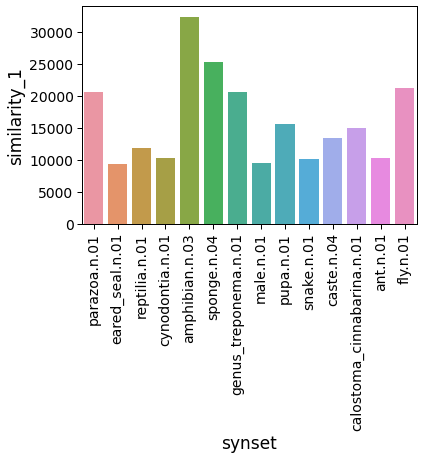

In [161]:
sim_threshold = 10_000
truncated_epochs = epochs[np.logical_or(epochs['similarity_1'] >= sim_threshold,
                                        epochs['similarity_2'] >= sim_threshold)]

sns.barplot(data=truncated_epochs, x='synset', y='similarity_1')
plt.xticks(rotation=90);

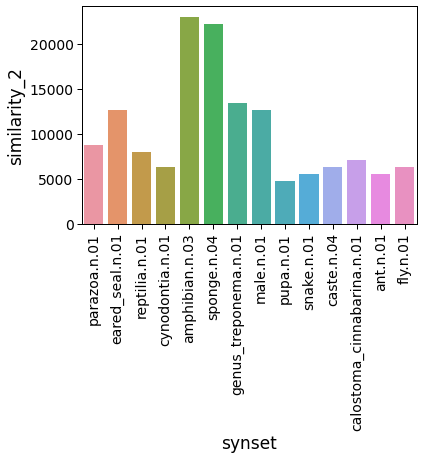

In [162]:
sns.barplot(data=truncated_epochs, x='synset', y='similarity_2')
plt.xticks(rotation=90);

In [163]:
def get_definition(ss, max_chars_num=70):
    definition = wn.synset(ss).definition()
    if len(definition) <= max_chars_num:
        return definition
    return definition[:max_chars_num] + '...'

In [164]:
compare_epoch1_df = pd.DataFrame({
    'synset': truncated_epochs['synset'],
    'score': truncated_epochs['similarity_1'] / np.sum(truncated_epochs['similarity_1']),
    'epoch': "1682-1916"
})
compare_epoch2_df = pd.DataFrame({
    'synset': truncated_epochs['synset'],
    'score': truncated_epochs['similarity_2'] / np.sum(truncated_epochs['similarity_2']),
    'epoch': "1918-1990"
})

compare_epochs_df = pd.concat([compare_epoch1_df, compare_epoch2_df])

compare_epochs_df['gloss'] = compare_epochs_df['synset'].apply(lambda ss: get_definition(ss))
compare_epochs_df.head()

,synset,score,epoch,gloss
33,parazoa.n.01,0.091484,1682-1916,multicellular organisms having less-specialize...
34,eared_seal.n.01,0.041619,1682-1916,pinniped mammal having external ear flaps and ...
37,reptilia.n.01,0.052529,1682-1916,class of cold-blooded air-breathing vertebrate...
49,cynodontia.n.01,0.045844,1682-1916,a division of the order Therapsida from the Tr...
50,amphibian.n.03,0.143200,1682-1916,cold-blooded vertebrate typically living on la...


In [165]:
def set_up_fonts():
    sns.set_context("paper", rc={
        "font.size": 15,"axes.titlesize": 15,"axes.labelsize": 17, "legend.fontsize": 17,
        "xtick.labelsize": 14, "ytick.labelsize": 14
    })

<AxesSubplot:xlabel='score', ylabel='gloss'>

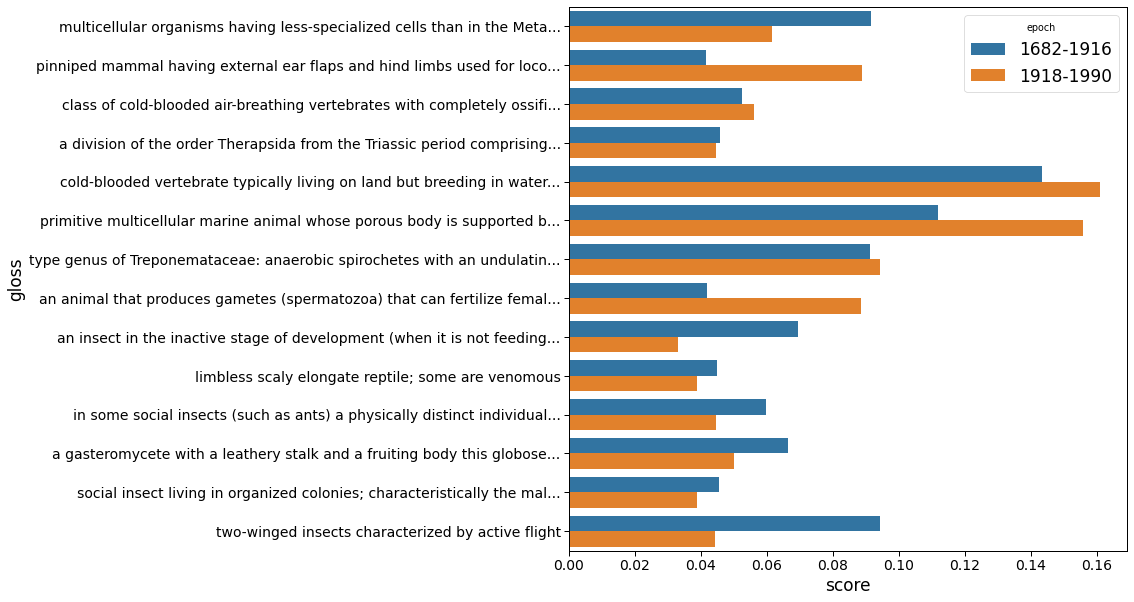

In [166]:
set_up_fonts()
plt.figure(figsize=(10, 10))
sns.barplot(data=compare_epochs_df, y='gloss', x='score', hue='epoch', orient='h')

In [11]:
compare_epochs_df[np.logical_and(compare_epochs_df['synset'] == 'magnifico.n.01', compare_epochs_df['epoch'] == 1)]

,synset,score,epoch,gloss


In [12]:
glosses_df = pd.DataFrame({'synset': compare_epochs_df['synset'].unique()})
glosses_df['gloss'] = glosses_df['synset'].apply(lambda ss: wn.synset(ss).definition())
pd.set_option('display.max_colwidth', None)

glosses_df

,synset,gloss
0,fat_cat.n.01,a wealthy and privileged person
1,quality.s.02,of high social status
2,rich_person.n.01,a person who possesses great material wealth
3,male_aristocrat.n.01,a man who is an aristocrat
4,aristocrat.n.01,a member of the aristocracy
5,quality.n.05,high social status
6,nobility.n.01,a privileged class holding hereditary titles
7,magnifico.n.01,a person of distinguished rank or appearance
8,colossus.n.02,a person of exceptional importance and reputation
9,estimable.a.01,deserving of respect or high regard


In [26]:
pd.set_option('display.max_colwidth', 50)